# 6. Decision Trees and Ensemble Learning

This week we'll talk about decision trees and tree-based ensemble methods.

## 6.1 Credit risk scoring project

- Dataset: [https://github.com/gastonstat/CreditScoring](https://github.com/gastonstat/CreditScoring)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 6.2 Data cleaning and preparation

- Downloading the dataset
- Preencoding the categorical variables

In [2]:
data = "https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv"

In [6]:
# !wget $data -d ./data

In [3]:
!head ./data/CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [4]:
df = pd.read_csv(data)

In [6]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
df.columns = df.columns.str.lower()

In [8]:
status_values = {1: "ok", 2: "default", 0: "unk"}
df.status = df.status.map(status_values)

In [9]:
home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unk",
}

df.home = df.home.map(home_values)

marital_status_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unk",
}

df.marital = df.marital.map(marital_status_values)

record_values = {1: "no", 2: "yes", 0: "unk"}

df.records = df.records.map(record_values)

job_values = {
    1: "fixed",
    2: "partime",
    3: "freelance",
    4: "others",
    0: "unk",
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
df.describe().round(2)

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,763316.99,1060340.81,404381.96,1039.02,1462.88
std,8.17,14.66,10.98,19.52,8703625.26,10217568.67,6344253.40,474.54,628.09
min,0.00,6.00,18.00,35.00,0.00,0.00,0.00,100.00,105.00
25%,2.00,36.00,28.00,35.00,80.00,0.00,0.00,700.00,1117.50
50%,5.00,48.00,36.00,51.00,120.00,3500.00,0.00,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,166.00,6000.00,0.00,1300.00,1692.00
max,48.00,72.00,68.00,180.00,99999999.00,99999999.00,99999999.00,5000.00,11140.00


`income`, `assets`, `debt`, have missing values set to 99999999.00, so we replace them with `np.nan`.

In [12]:
for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [13]:
df = df[df.status != "unk"].reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train.status == "default").astype(int).values
y_val = (df_val.status == "default").astype(int).values
y_test = (df_test.status == "default").astype(int).values

In [18]:
del df_train["status"]
del df_val["status"]
del df_test["status"]

## 6.3 Decision trees

- How a decision trees looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

<img src="./images/decision_tree.png" alt="Decision Tree" style="width:300px;height:auto;">

In [19]:
def assess_risk(client):
    if client["records"] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client["assets"] > 6000:
            return "ok"
        else:
            return "default"

In [20]:
xi = df_train.iloc[0].to_dict()

In [21]:
assess_risk(xi)

'ok'

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [23]:
train_dicts = df_train.fillna(0).to_dict(orient="records")

In [24]:
train_dicts[1]

{'seniority': 6,
 'home': 'parents',
 'time': 48,
 'age': 32,
 'marital': 'single',
 'records': 'yes',
 'job': 'fixed',
 'expenses': 35,
 'income': 85.0,
 'assets': 0.0,
 'debt': 0.0,
 'amount': 1100,
 'price': 1330}

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [27]:
dv.get_feature_names()

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [29]:
val_dicts = df_val.fillna(0).to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [30]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [31]:
roc_auc_score(y_val, y_pred)

0.6770361580005327

In [32]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Overfitting! Memorizing the training data is not the goal. We want to generalize to unseen data. Depth of tree is to big, so we need to control it.

In [33]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [34]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print("train auc:", auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("val auc:", auc)

train auc: 0.7761016984958594
val auc: 0.7389079944782155


In [35]:
from sklearn.tree import export_text

In [37]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



Play around with the `max_depth` parameter and see how it affects the tree.

## 6.4 Decision tree learning algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [38]:
data = [
    [8000, "default"],
    [2000, "default"],
    [0, "default"],
    [5000, "ok"],
    [5000, "ok"],
    [4000, "ok"],
    [9000, "ok"],
    [3000, "default"],
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [39]:
df_example.sort_values(by="assets")

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [40]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [41]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



<img src="./images/dt_impurity.png" alt="Decision Tree Impurity" style="width:400px;height:auto;">

In [42]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [0, 1000, "default"],
    [5000, 1000, "ok"],
    [5000, 1000, "ok"],
    [4000, 1000, "ok"],
    [9000, 500, "ok"],
    [3000, 2000, "default"],
]

df_example = pd.DataFrame(data, columns=["assets", "debt", "status"])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [43]:
df_example.sort_values(by="debt")

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [44]:
thresholds = {
    "assets": [0, 2000, 3000, 4000, 5000, 8000],
    "debt": [500, 2000, 3000],
}

In [45]:
for feature, Ts in thresholds.items():
    print("#" * 80)
    print(f"Feature: {feature}")
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print("#" * 80)

################################################################################
Feature: assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

################################################################################
################################################################################
Feature: debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

3000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)

################################################################################


## 6.5 Decision tree parameter tuning

- selecting `max_depth`
- selecting `min_samples_leaf`

In [46]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"depth: {str(d):>4} -> val auc: {auc:.3f}")

depth:    1 -> val auc: 0.606
depth:    2 -> val auc: 0.669
depth:    3 -> val auc: 0.739
depth:    4 -> val auc: 0.761
depth:    5 -> val auc: 0.767
depth:    6 -> val auc: 0.754
depth:   10 -> val auc: 0.699
depth:   15 -> val auc: 0.654
depth:   20 -> val auc: 0.650
depth: None -> val auc: 0.649


Best tree with `max_depth=4` because it is simpler.

In [47]:
scores = []

for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))
        # print(f"depth: {str(d):>4} min samples leaf: {str(s):>4} -> val auc: {auc:.3f}")

In [48]:
columns = ["max_depth", "min_samples_leaf", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


In [49]:
df_scores.sort_values(by="auc", ascending=False).head()

,max_depth,min_samples_leaf,auc
22,6,15,0.785080
21,6,10,0.777803
24,6,100,0.776434
23,6,20,0.774279
14,5,20,0.773537


In [50]:
df_scores_pivot = df_scores.pivot(
    index="min_samples_leaf", columns=["max_depth"], values=["auc"]
)
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.753
2                 0.761  0.767  0.760
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

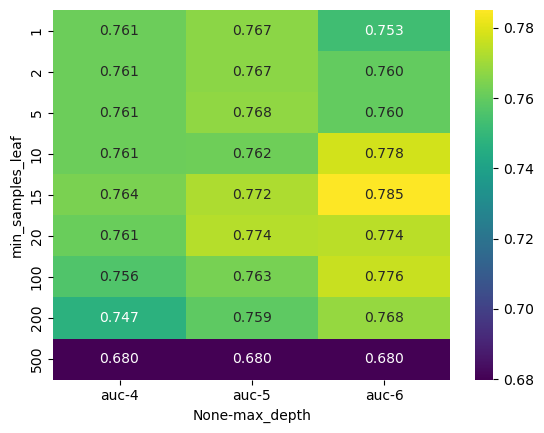

In [51]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.show();

Final model: `DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)`

In [52]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## 6.6 Ensembles and random forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [55]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [56]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    # print(f"n_estimators: {n} -> val auc: {auc:.3f}")
    scores.append((n, auc))

In [57]:
df_scores_rf = pd.DataFrame(scores, columns=["n_estimators", "auc"])

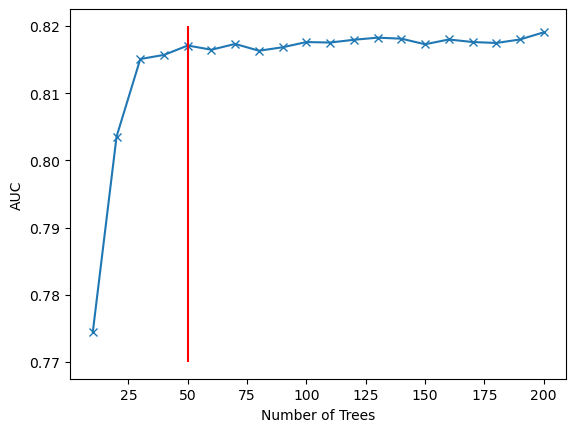

In [58]:
plt.plot(df_scores_rf.n_estimators, df_scores_rf.auc, marker="x")
plt.vlines(x=50, ymin=0.77, ymax=0.82, color="red")
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show();

50 experts seems to be enough.

In [59]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=n, max_depth=d, n_jobs=-1, random_state=1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        # print(f"n_estimators: {n} -> val auc: {auc:.3f}")
        scores.append((d, n, auc))

In [60]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores_rf = pd.DataFrame(scores, columns=columns)

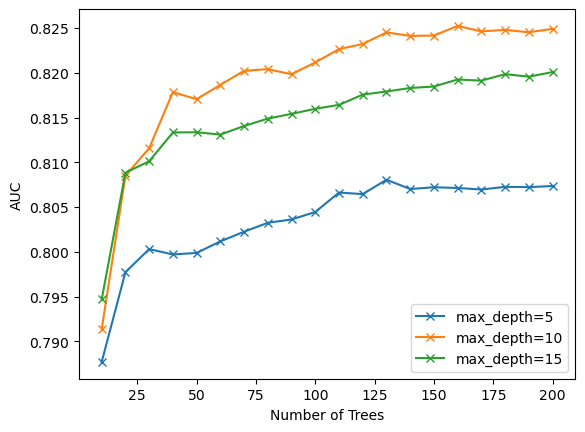

In [61]:
for d in [5, 10, 15]:
    df_subset = df_scores_rf[df_scores_rf.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, marker="x", label=f"max_depth={d}")
# plt.vlines(x=50, ymin=0.77, ymax=0.82, color="red")
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.legend()
plt.show();

`max_depth` = 10 is the best parameter for the random forest.

In [62]:
max_depth = 10

In [63]:
from tqdm.autonotebook import tqdm, trange

scores = []

for s in [1, 3, 5, 10, 50]:
    for n in trange(10, 201, 10, total=20):
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=max_depth,
            min_samples_leaf=s,
            n_jobs=-1,
            random_state=1,
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        # print(f"n_estimators: {n} -> val auc: {auc:.3f}")
        scores.append((s, n, auc))

/var/folders/r8/zdlnr35s6qz6zx67nmc9bdnm0000gn/T/ipykernel_62980/3987552656.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


In [64]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_scores_rf = pd.DataFrame(scores, columns=columns)
df_scores_rf.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


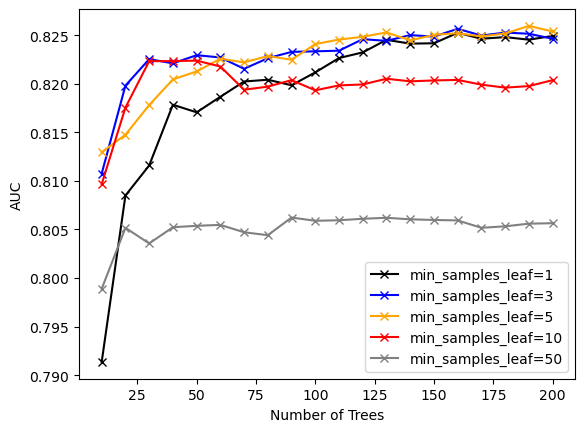

In [65]:
colors = ["black", "blue", "orange", "red", "grey"]
min_samples_leaf = [1, 3, 5, 10, 50]

for s, col in zip(min_samples_leaf, colors):
    df_subset = df_scores_rf[df_scores_rf.min_samples_leaf == s]
    plt.plot(
        df_subset.n_estimators,
        df_subset.auc,
        marker="x",
        label=f"min_samples_leaf={s}",
        color=col,
    )
# plt.vlines(x=50, ymin=0.77, ymax=0.82, color="red")
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.legend()
plt.show();


1, 3, 5 `min_samples_leaf` are the best parameters for the random forest. Not really clear

In [66]:
min_samples_leaf = 3

In [67]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    n_jobs=-1,
    random_state=1,
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

Other useful parameters:

- `max_features`
- `bootstrap`

[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## 6.7 Gradient boosting and XGBoost

- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [68]:
# !conda install xgboost -y

In [69]:
import xgboost as xgb

In [71]:
features = list(dv.get_feature_names())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [72]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [73]:
y_pred = model.predict(dval)

In [74]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

XGBoost tends to overfit, so be careful with `num_boost_round` parameter and `max_depth`.

In [75]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [76]:
%%capture output

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
)

In [77]:
# print(output.stdout)
# s = output.stdout
# line = s.split("\n")[0]
# num_iter, train_auc, val_auc = line.split("\t")
# int(num_iter.strip("[]"))
# float(train_auc.split(":")[1])
# float(val_auc.split(":")[1])

In [78]:
def parse_xgb_output(output) -> pd.DataFrame:
    """
    parse_xgb_output Parses the output of the xgboost training process to
    extract the number of iterations and the AUC values for the training and
    validation sets.
    """
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [79]:
df_score = parse_xgb_output(output)

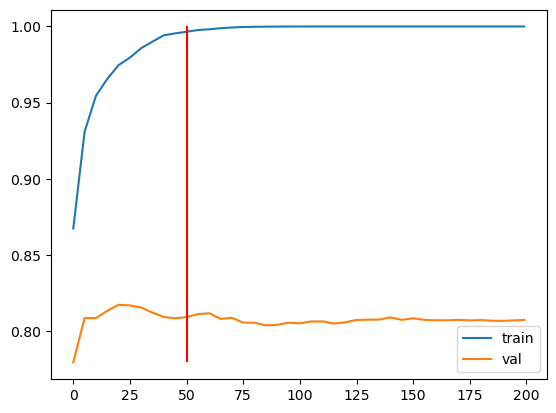

In [80]:
plt.plot(df_score.num_iter, df_score.train_auc, label="train")
plt.plot(df_score.num_iter, df_score.val_auc, label="val")
plt.vlines(x=50, ymin=0.78, ymax=1, color="red")
plt.legend()
plt.show();

See overfitting above 50 rounds, model starts declining on the validation set.

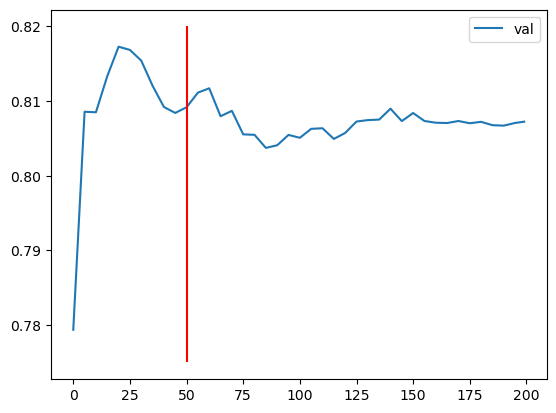

In [81]:
plt.plot(df_score.num_iter, df_score.val_auc, label="val")
plt.vlines(x=50, ymin=0.775, ymax=0.82, color="red")
plt.legend()
plt.show();

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

- `eta` => learning rate
- `max_depth`
- `min_child_weight`

In [82]:
scores = {}

run next cell several times with different parameters: `eta` = 0.01, 0.05, 0.1

In [89]:
%%capture output

xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
)


In [90]:
key = "eta=%s" % (xgb_params["eta"])
scores[key] = parse_xgb_output(output)

In [91]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.1'])

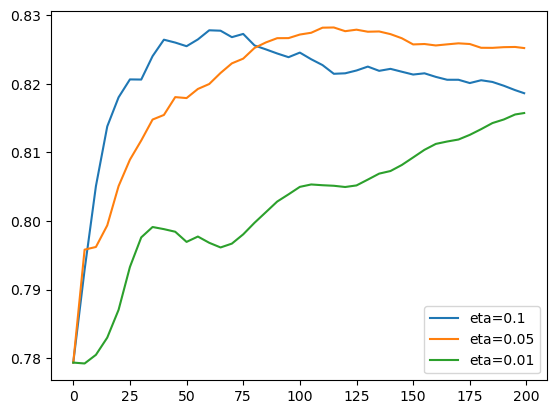

In [92]:
etas = ["eta=0.1", "eta=0.05", "eta=0.01"]

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()
plt.show();

eta = 0.1 is the best parameter.

Tuning order:
1. eta
2. max_depth
3. min_child_weight

In [93]:
scores = {}

In [102]:
%%capture output

xgb_params = {
    "eta": 0.1,
    "max_depth": 5,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
)


In [103]:
key = "max_depth=%s" % (xgb_params["max_depth"])
scores[key] = parse_xgb_output(output)

In [104]:
# del scores["max_depth=10"]

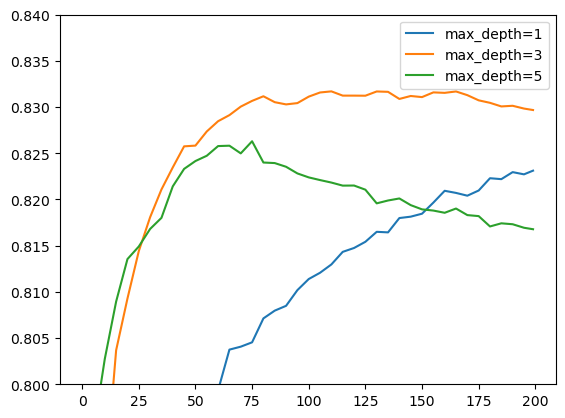

In [105]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.ylim(0.8, 0.84)
plt.legend()
plt.show();

max_depth = 3 is the best parameter.

In [118]:
scores = {}

In [128]:
%%capture output

xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
)

In [129]:
key = "min_child_weight=%s" % (xgb_params["min_child_weight"])
scores[key] = parse_xgb_output(output)

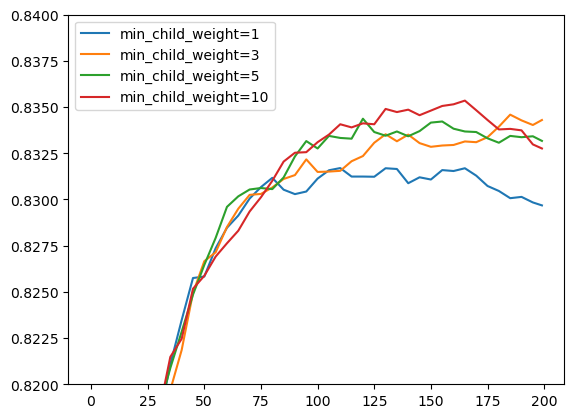

In [130]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.ylim(0.82, 0.84)
plt.legend()
plt.show();

min_child_weight = 1 is the best parameter (it`s the default).

175 iterations is the best number of iterations.

In [131]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=175
)

[0]	train-auc:0.77610	val-auc:0.73891
[5]	train-auc:0.83067	val-auc:0.77556
[10]	train-auc:0.84675	val-auc:0.78896
[15]	train-auc:0.86055	val-auc:0.80368
[20]	train-auc:0.86931	val-auc:0.80928
[25]	train-auc:0.87558	val-auc:0.81441
[30]	train-auc:0.88080	val-auc:0.81808
[35]	train-auc:0.88659	val-auc:0.82108
[40]	train-auc:0.89038	val-auc:0.82347
[45]	train-auc:0.89403	val-auc:0.82575
[50]	train-auc:0.89756	val-auc:0.82583
[55]	train-auc:0.90044	val-auc:0.82736
[60]	train-auc:0.90319	val-auc:0.82847
[65]	train-auc:0.90565	val-auc:0.82913
[70]	train-auc:0.90768	val-auc:0.83005
[75]	train-auc:0.91057	val-auc:0.83067
[80]	train-auc:0.91221	val-auc:0.83117
[85]	train-auc:0.91472	val-auc:0.83053
[90]	train-auc:0.91638	val-auc:0.83029
[95]	train-auc:0.91776	val-auc:0.83043
[100]	train-auc:0.91913	val-auc:0.83113
[105]	train-auc:0.92070	val-auc:0.83158
[110]	train-auc:0.92297	val-auc:0.83170
[115]	train-auc:0.92437	val-auc:0.83124
[120]	train-auc:0.92544	val-auc:0.83124
[125]	train-auc:0.9271

You can also use other sequence for tuning, just try different combinations.

Other parameters: [https://xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html)

Useful ones:

- `subsample` and `colsample_bytree`
- `lambda` and `alpha`



## 6.9 Selecting the final model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [132]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [133]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [134]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=1,
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

In [135]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [136]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=175
)

[0]	train-auc:0.77610	val-auc:0.73891
[5]	train-auc:0.83067	val-auc:0.77556
[10]	train-auc:0.84675	val-auc:0.78896
[15]	train-auc:0.86055	val-auc:0.80368
[20]	train-auc:0.86931	val-auc:0.80928
[25]	train-auc:0.87558	val-auc:0.81441
[30]	train-auc:0.88080	val-auc:0.81808
[35]	train-auc:0.88659	val-auc:0.82108
[40]	train-auc:0.89038	val-auc:0.82347
[45]	train-auc:0.89403	val-auc:0.82575
[50]	train-auc:0.89756	val-auc:0.82583
[55]	train-auc:0.90044	val-auc:0.82736
[60]	train-auc:0.90319	val-auc:0.82847
[65]	train-auc:0.90565	val-auc:0.82913
[70]	train-auc:0.90768	val-auc:0.83005
[75]	train-auc:0.91057	val-auc:0.83067
[80]	train-auc:0.91221	val-auc:0.83117
[85]	train-auc:0.91472	val-auc:0.83053
[90]	train-auc:0.91638	val-auc:0.83029
[95]	train-auc:0.91776	val-auc:0.83043
[100]	train-auc:0.91913	val-auc:0.83113
[105]	train-auc:0.92070	val-auc:0.83158
[110]	train-auc:0.92297	val-auc:0.83170
[115]	train-auc:0.92437	val-auc:0.83124
[120]	train-auc:0.92544	val-auc:0.83124
[125]	train-auc:0.9271

In [137]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

In [138]:
df_full_train = df_full_train.reset_index(drop=True)

In [139]:
y_full_train = (df_full_train.status == "default").astype(int).values

In [140]:
del df_full_train["status"]

In [141]:
dicts_full_train = df_full_train.fillna(0).to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient="records")
X_test = dv.transform(dicts_test)

In [145]:
dfulltrain = xgb.DMatrix(
    X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names())
)

dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names()))

In [146]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=175
)

[0]	train-auc:0.77610	val-auc:0.73891
[5]	train-auc:0.83067	val-auc:0.77556
[10]	train-auc:0.84675	val-auc:0.78896
[15]	train-auc:0.86055	val-auc:0.80368
[20]	train-auc:0.86931	val-auc:0.80928
[25]	train-auc:0.87558	val-auc:0.81441
[30]	train-auc:0.88080	val-auc:0.81808
[35]	train-auc:0.88659	val-auc:0.82108
[40]	train-auc:0.89038	val-auc:0.82347
[45]	train-auc:0.89403	val-auc:0.82575
[50]	train-auc:0.89756	val-auc:0.82583
[55]	train-auc:0.90044	val-auc:0.82736
[60]	train-auc:0.90319	val-auc:0.82847
[65]	train-auc:0.90565	val-auc:0.82913
[70]	train-auc:0.90768	val-auc:0.83005
[75]	train-auc:0.91057	val-auc:0.83067
[80]	train-auc:0.91221	val-auc:0.83117
[85]	train-auc:0.91472	val-auc:0.83053
[90]	train-auc:0.91638	val-auc:0.83029
[95]	train-auc:0.91776	val-auc:0.83043
[100]	train-auc:0.91913	val-auc:0.83113
[105]	train-auc:0.92070	val-auc:0.83158
[110]	train-auc:0.92297	val-auc:0.83170
[115]	train-auc:0.92437	val-auc:0.83124
[120]	train-auc:0.92544	val-auc:0.83124
[125]	train-auc:0.9271

In [147]:
y_pred = model.predict(dtest)

In [148]:
roc_auc_score(y_test, y_pred)

0.8175309124676214

## 6.10 Summary

- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combining multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.

## 6.11 Explore more

- For this dataset we didn´t do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
- There´s a variation of random forest called "extremely randomized trees", or "extra trees". Insted of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
- XGBoost can deal with NAs - we don´t have to do `fillna` for it. Check if not filling NA´s help improve performance.
- Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than others. See example here for [random forest](?) (it´s the same for plain decision trees) and for [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
- Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.

## 7.1 Credit risk as a service

![Credit risk as a service](./images/credit_risk_as_a_service.png "Credit risk as a service")

### What are the goals of this module?

- Build and deploy a ML Service
- Customize your service to fit your use case
- Make your service *production-ready*

### What is production ready?

1. **Scalability**: can handle a large number of requests
2. **Operational efficiency**: can be easily monitored and maintained
3. **Repeatability (CI/CD)**: can be easily updated and redeployed
4. **Flexibility**: can be easily customized to fit different use cases
5. **Resilience**: can handle errors and unexpected situations, go back to a stable state
6. **Easy to use -ity**: can be easily used by other developers

### What is a Bento?

🍱

- Code
- Model(s)
- Data
- Dependencies
- Configuration
- Deployment logic
- Etc...

BentoML makes it easy to create and package your ML service for production.

## 7.2 Building a prediction service

first, install BentoML:

```bash
pip install bentoml
# or
conda install bentoml
```

and check the version:

```bash
bentoml --version
```

In [149]:
import bentoml

In [150]:
bentoml.__version__

'1.0.15'

In [154]:
bentoml.xgboost.save_model(
    "credit_risk_model",
    model,
    custom_objects={"dictVectorizer": dv},
    signatures={  # model signatures for runner inference
        "predict": {
            "batchable": True,
            "batch_dim": 0,
        }
    },
)

Model(tag="credit_risk_model:j35ikpewco6t3pxe", path="/Users/tillmeineke/bentoml/models/credit_risk_model/j35ikpewco6t3pxe/")

In [153]:
dv.get_feature_names()

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

Create a [`service.py`](./service.py) file:

```python
import bentoml

from bentoml.io import JSON

model_ref = bentoml.xgboost.get("credit_risk_model:latest")
dv = model_ref.custom_objects["dictVectorizer"]

model_runner = model_ref.to_runner()

svc = bentoml.Service("credit_risk_classifier", runners=[model_runner])


@svc.api(input=JSON(), output=JSON())
def classify(application_data):
    vector = dv.transform(application_data)
    prediction = model_runner.predict.run(vector)
    print(prediction)

    result = prediction[0]

    if result > 0.5:
        return {"status": "DECLINED"}
    elif result > 0.25:
        return {"status": "MAYBE"}
    else:
        return {"status": "Approved"}
```

Start the service:

```bash
bentoml serve service.py:svc --reload
```

check the service on [BentoML local](http://localhost:3000)

## 7.3 Deploying your prediction service

list models:

```bash
bentoml models list
```

inspect the model:

```bash
bentoml models get <MODEL_TAG>
```

```plaintext
name: credit_risk_model
version: h75yenewbg6t3pxe
module: bentoml.xgboost
labels: {}
options:
  model_class: Booster
metadata: {}
context:
  framework_name: xgboost
  framework_versions:
    xgboost: 2.1.1
  bentoml_version: 1.0.15
  python_version: 3.8.12
signatures:
  predict:
    batchable: false
api_version: v2
creation_time: '2024-10-29T15:19:54.410409+00:00'
```

see version of python, framework, bentoml

create [`bentofile.yaml`](./bentofile.yaml) file:

```yaml
service: "service.py:svc"
labels:
  owner: bentoml-team
  project: gallery
include:
- "*.py"
python:
  packages:
   - xgboost
   - sklearn
```

Build the service:

```bash
bentoml build
```

change into the build directory

```bash
cd ~/bentoml/bentos/credit_risk_classifier
```

change into the directory

```bash
cd wbqpt3uwborfbpxe
tree
```



move back into project folder and run:

```bash
bentoml containerize credit_risk_classifier:wbqpt3uwborfbpxe
```

run docker container:

```bash
docker run -it --rm -p 3000:3000 credit_risk_classifier:wbqpt3uwborfbpxe # or whatever the container id is
```

## 7.4 Anatomy of a BentoML service

### Sending, Recieving and Validating Data

check [docs](https://docs.bentoml.com/en/1.1/reference/api_io_descriptors.html)

## 7.5 Customizing Bentos

## 7.6 BentoML Production Deployment

- install aws cli
- configure aws cli
  - `aws configure`
- check connection
  - `aws s3 ls`
- AWS elastic container registry follow instructions
- AWS elastic container service follow instructions
  - first we need a cluster -> create cluster, choose networking only (Fargate)
    - configure cluster, give name and keep defaults
  - second we need a task definition -> create task definition (Fargate)
    - configure task, give name, task role keep empty, operating system family linux, task memory 0.5GB, task CPU 0.25 vCPU, add container you uploaded to ECR, Memory limit Soft limit 256 (for bursts, add hard limit for larger models), port mapping 3000 and add
  - back in clusters: configure fargate
    - Configure security group, add custom TCP rule, port range 3000
  - back to the task: run task
    - check public IP

chack out Amazon SageMaker for more advanced deployment options (more expensive)

moving bentos

```bash
bentoml export --help
```
push to local registry or remote (S3 bucket) or import

```bash
bentoml import --help
```

## 7.7 High Performance serving (changed to 7.5 ?)

locust.io as a load testing tool

await async in the service

add signatures when saving the model

run the service with:

```bash
bentoml serve --production service.py:svc
```

Guide for [adaptive batching](https://docs.bentoml.com/en/1.1/guides/batching.html)

- Max batch size
- Max latency

configure in a [`bentoconfiguration.yaml`](./bentoconfiguration.yaml) file

buildin on M1 Macs, run:

```bash
bentoml build
benotml containerize --platform=linux/amd64 credit_risk_classifier:wbqpt3uwborfbpxe
```


## 7.8 Custom Runner / framework